In [45]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.colors as mcolors

from matplotlib import style
style.use("seaborn")
style.use('ggplot')
import matplotlib.pyplot as plt

from mmtwfs.wfs import WFSFactory

%load_ext autoreload
%autoreload 2
#%matplotlib widget

SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# instantiate all of the WFS systems...
wfs_keys = ['f9', 'newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

# map f9 to oldf9
wfs_systems['oldf9'] = wfs_systems['f9']
plt.close('all')

In [3]:
rootdir = Path("/mnt/f/wfsdat")
# use find to make this csv list
with open(rootdir / "all_seeing.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [4]:
g = data.groupby('wfs')
g.wfs.describe()

count unique       top    freq
wfs                                      
binospec  102020      1  binospec  102020
f5         98774      1        f5   98774
mmirs      81270      1     mmirs   81270
newf9       3047      1     newf9    3047
oldf9      55728      1     oldf9   55728

In [20]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
#data['seeing'][data['seeing'].apply(isinstance, args=(str,))] = 0.0
fixed = data[[isinstance(x, float) for x in data['seeing']]]
fixed['seeing'] = fixed['seeing'].astype(float)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.25]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[np.isfinite(fixed['airmass'])]
#fixed = fixed[fixed['time'] < "2020-12-31"]

tracking_fwhm = stats.gaussian_sigma_to_fwhm * 0.15
fixed['seeing_corr'] = np.sqrt(fixed['seeing']**2 - tracking_fwhm**2) 

<ipython-input-20-7ac7b65f69c9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['seeing'] = fixed['seeing'].astype(float)
/home/tim/conda/envs/py38/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
def correct_tracking(row, tracking_sigma=0.15):
    w = wfs_systems[row['wfs']]
    raw_sigma = stats.gaussian_fwhm_to_sigma * row['fwhm']
    tracking_sigma = tracking_sigma / w.pix_size.value
    sigma = raw_sigma**2 - tracking_sigma**2
    if sigma > 0:
        sigma = np.sqrt(sigma)
    else:
        sigma = 0.0
    mode = w.default_mode
    seeing, raw_seeing = w.seeing(mode, sigma, airmass=row['airmass'])
    return seeing

In [66]:
seeing_corr = []
for i, row in fixed.iterrows():
    seeing_corr.append(correct_tracking(row).value)

In [67]:
fixed['seeing_corr'] = seeing_corr
fixed

time       wfs  \
ut                                                              
2003-04-11 06:30:09.000         2003-04-11T06:30:09     oldf9   
2003-04-11 06:31:07.000         2003-04-11T06:31:07     oldf9   
2003-04-11 06:33:55.000         2003-04-11T06:33:55     oldf9   
2003-04-11 06:34:38.000         2003-04-11T06:34:38     oldf9   
2003-04-11 06:36:36.000         2003-04-11T06:36:36     oldf9   
...                                             ...       ...   
2021-04-08 11:52:54.858  2021-04-08T11:52:54.858000  binospec   
2021-04-08 11:53:38.102  2021-04-08T11:53:38.102000  binospec   
2021-04-08 11:54:21.338  2021-04-08T11:54:21.338000  binospec   
2021-04-08 11:55:04.579  2021-04-08T11:55:04.579000  binospec   
2021-04-08 11:55:47.849  2021-04-08T11:55:47.849000  binospec   

                                                         file  exptime  \
ut                                                                       
2003-04-11 06:30:09.000           20030410_big_run2_0000.fits     20.0   
2003-04-11 06:31:07.000           20030410_big_run2_0001.fits     30.0   
2003-04-11 06:33:55.000           20030410_big_run3_0000.fits     10.0   
2003-04-11 06:34:38.000           20030410_big_run3_0001.fits     20.0   
2003-04-11 06:36:36.000           20030410_big_run3_0002.fits     20.0   
...                                                       ...      ...   
2021-04-08 11:52:54.858  wfs_ff_cal_img_2021.0408.115254.fits     40.0   
2021-04-08 11:53:38.102  wfs_ff_cal_img_2021.0408.115338.fits     40.0   
2021-04-08 11:54:21.338  wfs_ff_cal_img_2021.0408.115421.fits     40.0   
2021-04-08 11:55:04.579  wfs_ff_cal_img_2021.0408.115504.fits     40.0   
2021-04-08 11:55:47.849  wfs_ff_cal_img_2021.0408.115547.fits     40.0   

                         airmass          az         el  osst  outt  chamt  \
ut                                                                           
2003-04-11 06:30:09.000   1.0980   91.986000  65.593000   NaN   NaN    NaN   
2003-04-11 06:31:07.000   1.0960   92.127000  65.798000   NaN   NaN    NaN   
2003-04-11 06:33:55.000   1.0860   95.818000  67.068000   NaN   NaN    NaN   
2003-04-11 06:34:38.000   1.0850   95.949000  67.223000   NaN   NaN    NaN   
2003-04-11 06:36:36.000   1.0810   96.310000  67.640000   NaN   NaN    NaN   
...                          ...         ...        ...   ...   ...    ...   
2021-04-08 11:52:54.858   1.3239  316.166560  49.053621  9.28   9.4  9.206   
2021-04-08 11:53:38.102   1.3261  316.134384  48.948103  9.25   9.4  9.096   
2021-04-08 11:54:21.338   1.3282  316.102874  48.841662  9.28   9.3  9.094   
2021-04-08 11:55:04.579   1.3304  316.072393  48.733548  9.32   9.3  9.173   
2021-04-08 11:55:47.849   1.3326  316.041988  48.625069  9.30   9.3  9.269   

                         ...  cc_x_err  cc_y_err        xcen        ycen  \
ut                       ...                                               
2003-04-11 06:30:09.000  ...    -0.597     0.547  265.017179  266.006176   
2003-04-11 06:31:07.000  ...    -0.000     2.751  262.986726  268.007654   
2003-04-11 06:33:55.000  ...    -5.266     0.000  260.977495  268.010815   
2003-04-11 06:34:38.000  ...    -3.113     0.000  265.014998  269.000811   
2003-04-11 06:36:36.000  ...    -0.000    -0.000  267.990510  261.997154   
...                      ...       ...       ...         ...         ...   
2021-04-08 11:52:54.858  ...    -1.703     0.000  276.012870  248.986231   
2021-04-08 11:53:38.102  ...    -0.955     0.000  276.993555  249.013150   
2021-04-08 11:54:21.338  ...    -1.401     0.000  277.008188  248.988648   
2021-04-08 11:55:04.579  ...    -1.526     0.000  277.983364  248.016150   
2021-04-08 11:55:47.849  ...    -0.985    -0.000  277.005863  250.003324   

                           seeing  raw_seeing       fwhm  wavefront_rms  \
ut                                                                        
2003-04-11 06:30:09.000  0.370091    0.370091   4.120060     998.309217   
2003-04-1

In [68]:
fixed.sort_values(by='time')

time       wfs  \
ut                                                              
2003-04-11 04:46:44.000         2003-04-11T04:46:44     oldf9   
2003-04-11 04:47:06.000         2003-04-11T04:47:06     oldf9   
2003-04-11 04:47:27.000         2003-04-11T04:47:27     oldf9   
2003-04-11 04:52:40.000         2003-04-11T04:52:40     oldf9   
2003-04-11 04:55:15.000         2003-04-11T04:55:15     oldf9   
...                                             ...       ...   
2021-04-08 11:52:54.858  2021-04-08T11:52:54.858000  binospec   
2021-04-08 11:53:38.102  2021-04-08T11:53:38.102000  binospec   
2021-04-08 11:54:21.338  2021-04-08T11:54:21.338000  binospec   
2021-04-08 11:55:04.579  2021-04-08T11:55:04.579000  binospec   
2021-04-08 11:55:47.849  2021-04-08T11:55:47.849000  binospec   

                                                         file  exptime  \
ut                                                                       
2003-04-11 04:46:44.000              20030410_start_0001.fits     20.0   
2003-04-11 04:47:06.000              20030410_start_0002.fits     20.0   
2003-04-11 04:47:27.000              20030410_start_0003.fits     20.0   
2003-04-11 04:52:40.000          20030410_start_cor_0000.fits     20.0   
2003-04-11 04:55:15.000          20030410_start_cor_0001.fits     20.0   
...                                                       ...      ...   
2021-04-08 11:52:54.858  wfs_ff_cal_img_2021.0408.115254.fits     40.0   
2021-04-08 11:53:38.102  wfs_ff_cal_img_2021.0408.115338.fits     40.0   
2021-04-08 11:54:21.338  wfs_ff_cal_img_2021.0408.115421.fits     40.0   
2021-04-08 11:55:04.579  wfs_ff_cal_img_2021.0408.115504.fits     40.0   
2021-04-08 11:55:47.849  wfs_ff_cal_img_2021.0408.115547.fits     40.0   

                         airmass          az         el  osst  outt  chamt  \
ut                                                                           
2003-04-11 04:46:44.000   1.0600  177.889000  70.693000   NaN   NaN    NaN   
2003-04-11 04:47:06.000   1.0600  178.162000  70.696000   NaN   NaN    NaN   
2003-04-11 04:47:27.000   1.0600  178.427000  70.699000   NaN   NaN    NaN   
2003-04-11 04:52:40.000   1.0600  182.299000  70.698000   NaN   NaN    NaN   
2003-04-11 04:55:15.000   1.0600  184.205000  70.670000   NaN   NaN    NaN   
...                          ...         ...        ...   ...   ...    ...   
2021-04-08 11:52:54.858   1.3239  316.166560  49.053621  9.28   9.4  9.206   
2021-04-08 11:53:38.102   1.3261  316.134384  48.948103  9.25   9.4  9.096   
2021-04-08 11:54:21.338   1.3282  316.102874  48.841662  9.28   9.3  9.094   
2021-04-08 11:55:04.579   1.3304  316.072393  48.733548  9.32   9.3  9.173   
2021-04-08 11:55:47.849   1.3326  316.041988  48.625069  9.30   9.3  9.269   

                         ...  cc_x_err  cc_y_err        xcen        ycen  \
ut                       ...                                               
2003-04-11 04:46:44.000  ...     0.000    -0.000  260.015521  267.004039   
2003-04-11 04:47:06.000  ...     0.000    -0.000  259.989181  266.980205   
2003-04-11 04:47:27.000  ...     0.000    -0.622  260.020751  266.977415   
2003-04-11 04:52:40.000  ...     0.000    -0.000  257.009320  269.976762   
2003-04-11 04:55:15.000  ...    -0.000    -0.000  254.984789  273.000265   
...                      ...       ...       ...         ...         ...   
2021-04-08 11:52:54.858  ...    -1.703     0.000  276.012870  248.986231   
2021-04-08 11:53:38.102  ...    -0.955     0.000  276.993555  249.013150   
2021-04-08 11:54:21.338  ...    -1.401     0.000  277.008188  248.988648   
2021-04-08 11:55:04.579  ...    -1.526     0.000  277.983364  248.016150   
2021-04-08 11:55:47.849  ...    -0.985    -0.000  277.005863  250.003324   

                           seeing  raw_seeing      fwhm  wavefront_rms  \
ut                                                                       
2003-04-11 04:46:44.000  0.977057    0.977057  7.205232     765.359307   
2003-04-11 0

In [69]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [70]:
fixed['seeing'].median(), fixed['seeing_corr'].median()

(0.9876690426277692, 0.8851849127507604)

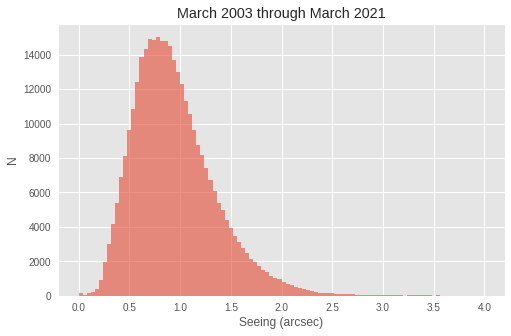

In [71]:
# make raw histogram of the zenith-corrected seeing column
#fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing_corr'], bins=100, range=(0.0, 4.), alpha=0.6)
    plt.title("March 2003 through March 2021")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [72]:
# fit a log-normal distribution to the seeing data
seeing = np.array(fixed['seeing_corr'], dtype=float)
seeing = seeing[np.isfinite(seeing)]
sigma, loc, exp_mu = lognorm.fit(seeing)
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(seeing)
fit_median = exp_mu + loc

0.31443576053345745 -0.3136166879162212 1.200038304203507


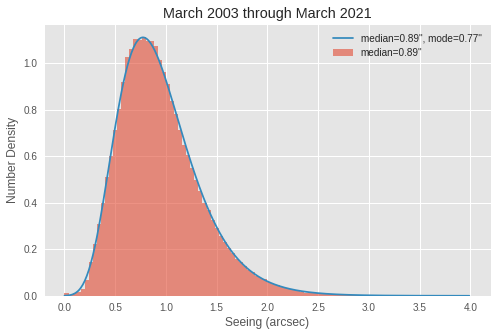

In [73]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing_corr'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("March 2003 through March 2021")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("all_hist.png")
    plt.savefig("all_hist.pdf")
plt.show()

In [74]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.nanmedian(first_half['seeing_corr'])
med_2nd = np.nanmedian(second_half['seeing_corr'])

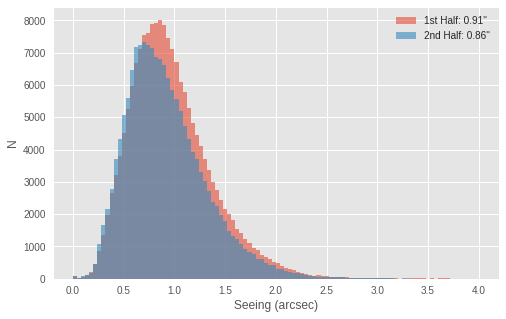

In [75]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing_corr'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing_corr'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("all_1st2nd.png")
plt.savefig("all_1st2nd.pdf")
plt.show()

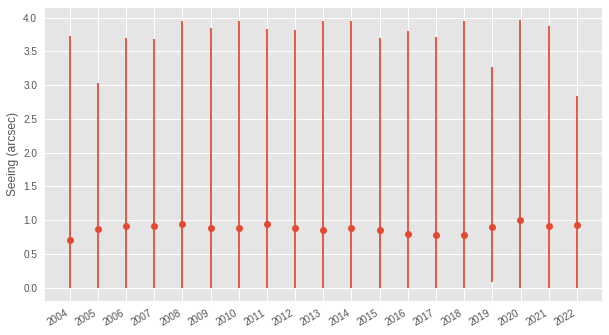

In [76]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots(figsize=(10, 6))
monthly = pd.DataFrame()
monthly['seeing'] = fixed.seeing_corr.resample('Y').median()
monthly['max'] = fixed.seeing_corr.resample('Y').max()
monthly['min'] = fixed.seeing_corr.resample('Y').min()
lowb = monthly['seeing'] - monthly['min']
upb = monthly['max'] - monthly['seeing']
plt.errorbar(monthly.index, monthly['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("all_nightly.png")
plt.savefig("all_nightly.pdf")
plt.show()

In [77]:
month_list = list(monthly.index.strftime('%Y'))
data = [np.array(fixed.loc[month]['seeing_corr']) for month in month_list]
clean_data = {}
for d, arr in zip(month_list, data):
    if len(arr) > 0:
        clean_data[d] = arr[np.isfinite(arr)]
month_labels = [datetime.strptime(d, "%Y").date() for d in clean_data.keys()]
sizes = [len(clean_data[y]) for y in clean_data]

In [78]:
first_meds = []
sec_meds = []
for y in clean_data:
    year = fixed.loc[y]
    first_half = year.between_time(start_time='00:00', end_time='07:00')
    second_half = year.between_time(start_time='07:00', end_time='14:00')
    med_1st = np.nanmedian(first_half['seeing_corr'])
    med_2nd = np.nanmedian(second_half['seeing_corr'])
    first_meds.append(med_1st)
    sec_meds.append(med_2nd)
    print(f"{y}: {med_1st:.2f} {med_2nd:.2f}")

2003: 0.71 0.71
2004: 0.85 0.90
2005: 0.99 0.85
2006: 0.91 0.93
2007: 0.98 0.90
2008: 0.89 0.87
2009: 0.86 0.90
2010: 0.96 0.93
2011: 0.90 0.86
2012: 0.86 0.84
2013: 0.94 0.79
2014: 0.89 0.80
2015: 0.85 0.74
2016: 0.84 0.74
2017: 0.79 0.76
2018: 0.91 0.89
2019: 1.01 1.00
2020: 0.95 0.88
2021: 0.99 0.88


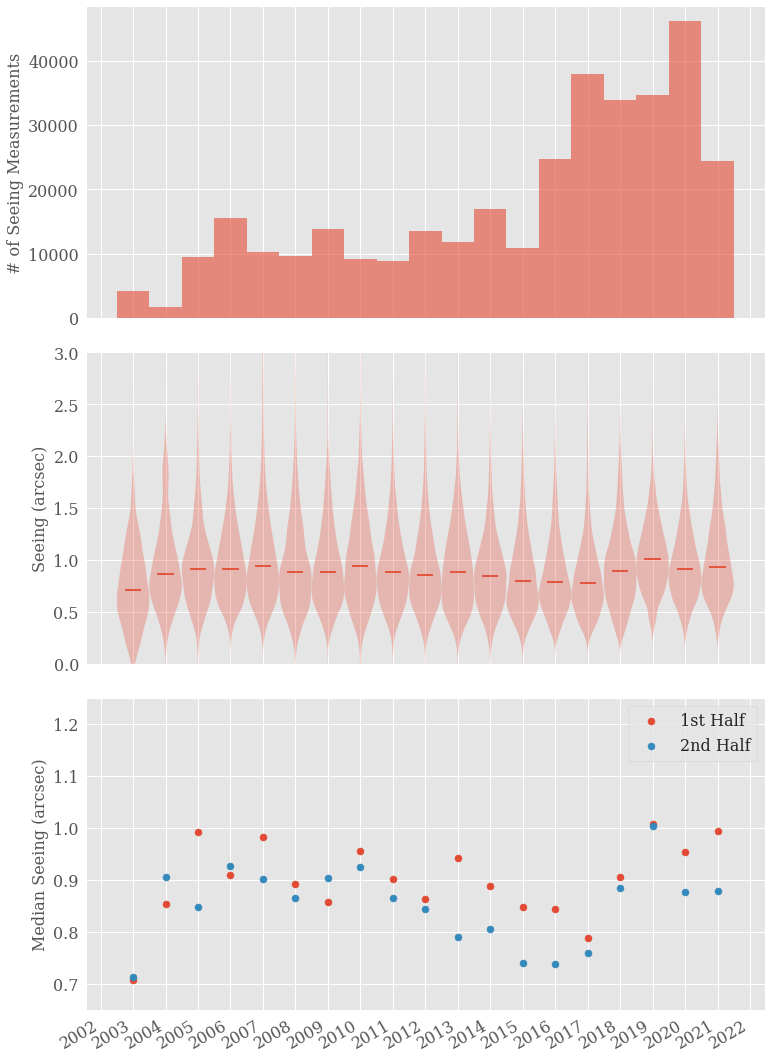

In [80]:
with plt.style.context('ggplot'):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    fig, ax = plt.subplots(3, figsize=(11,15), sharex=True)
    ax[0].bar(mdates.date2num(month_labels), sizes, width=366, alpha=0.6)
    ax[0].set_ylabel("# of Seeing Measurements")
    ax[1].violinplot(clean_data.values(), mdates.date2num(month_labels), points=100, widths=365,
                showextrema=False, showmedians=True, bw_method='silverman')


    ax[1].set_ylim(0.0, 3.0)
    ax[1].set_ylabel("Seeing (arcsec)")
    ax[2].scatter(mdates.date2num(month_labels), first_meds, label="1st Half")
    ax[2].scatter(mdates.date2num(month_labels), sec_meds, label="2nd Half")
    ax[2].legend(frameon=True, fancybox=True)
    ax[2].set_ylim(0.65, 1.25)
    ax[2].set_ylabel("Median Seeing (arcsec)")
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.savefig("all_violin.png")
    plt.savefig("all_violin.pdf")
    plt.show()

In [21]:
[len(clean_data[y]) for y in clean_data]

[4157,
 1751,
 9491,
 15561,
 10326,
 9686,
 13914,
 9217,
 8842,
 13509,
 11768,
 16896,
 10823,
 24738,
 37888,
 33842,
 34695,
 46168,
 24495]

In [22]:
diff = fixed['osst'] - fixed['outt']
trim_seeing = fixed['seeing'][np.abs(diff) < 100]
diff = diff[np.abs(diff) < 100]

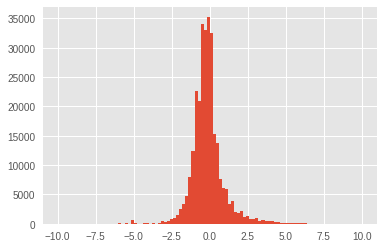

In [23]:
plt.hist(diff, bins=100, range=(-10, 10))
plt.show()

In [24]:
temps = list(range(-3,6))
t_meds = []
for t in temps:
    seeing_slice = trim_seeing[(diff >= t-0.5) & (diff <= t+0.5)]
    t_meds.append(np.median(seeing_slice))
t_meds, temps

([1.1389170340225985,
  1.0082133493904204,
  0.9472973759470648,
  0.9698903816056036,
  1.0538520702219996,
  1.1264048147264316,
  1.2477153292708285,
  1.2826657435759314,
  1.4298977456996254],
 [-3, -2, -1, 0, 1, 2, 3, 4, 5])

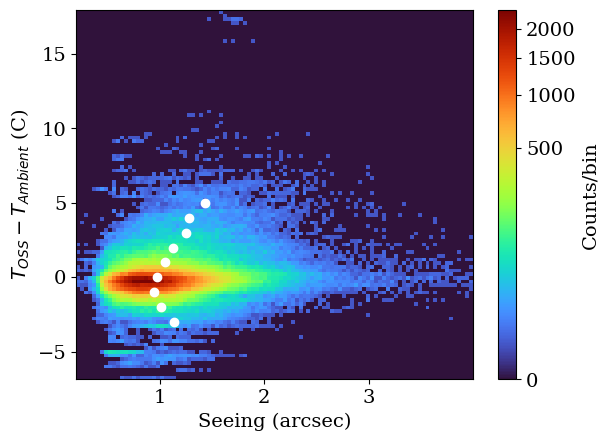

In [25]:
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(trim_seeing, diff, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("$T_{OSS} - T_{Ambient}$ (C)")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(t_meds, temps, color='w')
    plt.savefig("seeing_tempdiff.png")
    plt.savefig("seeing_tempdiff.pdf")
    plt.show()

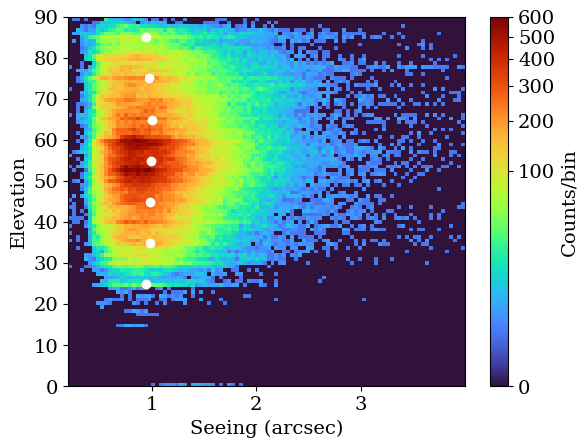

In [26]:
trimmed = fixed[np.isfinite(fixed['seeing']) & np.isfinite(fixed['el'])]
trim_el = trimmed['el'].astype(float)
el_seeing = trimmed['seeing'].astype(float)
els = [25, 35, 45, 55, 65, 75, 85]
e_meds = []
for el in els:
    seeing_slice = el_seeing[(trim_el >= el-5) & (trim_el <= el+5)]
    e_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(el_seeing, trim_el, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Elevation")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(e_meds, els, color='w')
    plt.savefig("seeing_elevation.png")
    plt.savefig("seeing_elevation.pdf")
    plt.show()

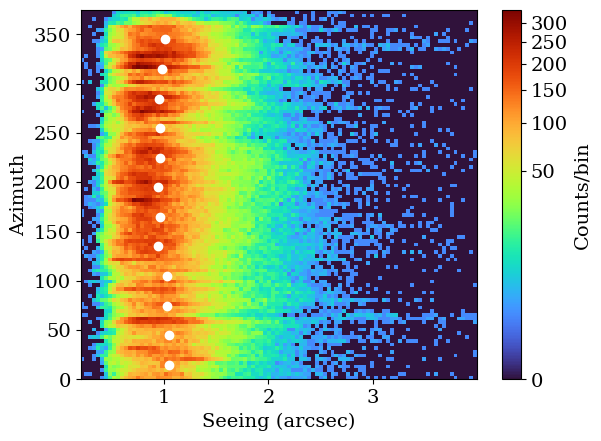

In [27]:
trimmed = fixed[np.isfinite(fixed['seeing']) & np.isfinite(fixed['az'])]
trim_az = trimmed['az'].astype(float)
trim_az[trim_az < 0] += 360.
az_seeing = trimmed['seeing'].astype(float)
azs = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
a_meds = []
for az in azs:
    seeing_slice = az_seeing[(trim_az >= az-15) & (trim_az <= az+15)]
    a_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(az_seeing, trim_az, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Azimuth")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(a_meds, azs, color='w')
    plt.savefig("seeing_azimuth.png")
    plt.savefig("seeing_azimuth.pdf")
    plt.show()

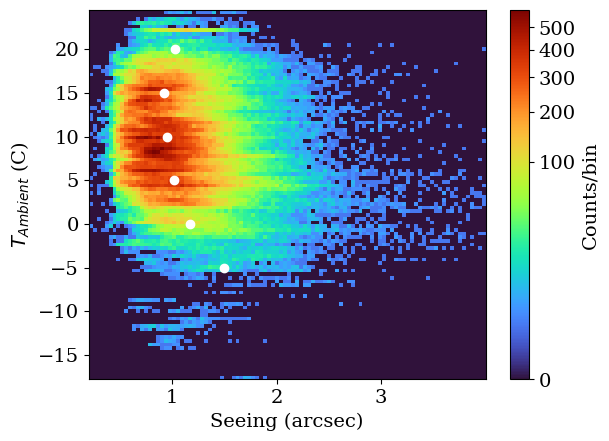

In [28]:
trimmed = fixed[np.isfinite(fixed['seeing']) & np.isfinite(fixed['outt'])]
trim_outt = trimmed['outt'].astype(float)
outt_seeing = trimmed['seeing'].astype(float)
temps = list(range(-5, 25, 5))
temps_meds = []
for t in temps:
    seeing_slice = outt_seeing[(trim_outt >= t-2.5) & (trim_outt <= t+2.5)]
    temps_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(outt_seeing, trim_outt, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("$T_{Ambient}$ (C)")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(temps_meds, temps, color='w')
    plt.savefig("seeing_ambient.pdf")
    plt.savefig("seeing_ambient.png")
    plt.show()

In [215]:
temps

[-5, 0, 5, 10, 15, 20]

In [36]:
fixed.columns

Index(['time', 'wfs', 'file', 'exptime', 'airmass', 'az', 'el', 'osst', 'outt',
       'chamt', 'tiltx', 'tilty', 'transx', 'transy', 'focus', 'focerr',
       'cc_x_err', 'cc_y_err', 'xcen', 'ycen', 'seeing', 'raw_seeing', 'fwhm',
       'wavefront_rms', 'residual_rms'],
      dtype='object')

In [37]:
fixed

time       wfs  \
ut                                                              
2003-04-11 06:30:09.000         2003-04-11T06:30:09     oldf9   
2003-04-11 06:31:07.000         2003-04-11T06:31:07     oldf9   
2003-04-11 06:33:55.000         2003-04-11T06:33:55     oldf9   
2003-04-11 06:34:38.000         2003-04-11T06:34:38     oldf9   
2003-04-11 06:36:36.000         2003-04-11T06:36:36     oldf9   
...                                             ...       ...   
2021-04-08 11:52:54.858  2021-04-08T11:52:54.858000  binospec   
2021-04-08 11:53:38.102  2021-04-08T11:53:38.102000  binospec   
2021-04-08 11:54:21.338  2021-04-08T11:54:21.338000  binospec   
2021-04-08 11:55:04.579  2021-04-08T11:55:04.579000  binospec   
2021-04-08 11:55:47.849  2021-04-08T11:55:47.849000  binospec   

                                                         file  exptime  \
ut                                                                       
2003-04-11 06:30:09.000           20030410_big_run2_0000.fits     20.0   
2003-04-11 06:31:07.000           20030410_big_run2_0001.fits     30.0   
2003-04-11 06:33:55.000           20030410_big_run3_0000.fits     10.0   
2003-04-11 06:34:38.000           20030410_big_run3_0001.fits     20.0   
2003-04-11 06:36:36.000           20030410_big_run3_0002.fits     20.0   
...                                                       ...      ...   
2021-04-08 11:52:54.858  wfs_ff_cal_img_2021.0408.115254.fits     40.0   
2021-04-08 11:53:38.102  wfs_ff_cal_img_2021.0408.115338.fits     40.0   
2021-04-08 11:54:21.338  wfs_ff_cal_img_2021.0408.115421.fits     40.0   
2021-04-08 11:55:04.579  wfs_ff_cal_img_2021.0408.115504.fits     40.0   
2021-04-08 11:55:47.849  wfs_ff_cal_img_2021.0408.115547.fits     40.0   

                         airmass          az         el  osst  outt  chamt  \
ut                                                                           
2003-04-11 06:30:09.000   1.0980   91.986000  65.593000   NaN   NaN    NaN   
2003-04-11 06:31:07.000   1.0960   92.127000  65.798000   NaN   NaN    NaN   
2003-04-11 06:33:55.000   1.0860   95.818000  67.068000   NaN   NaN    NaN   
2003-04-11 06:34:38.000   1.0850   95.949000  67.223000   NaN   NaN    NaN   
2003-04-11 06:36:36.000   1.0810   96.310000  67.640000   NaN   NaN    NaN   
...                          ...         ...        ...   ...   ...    ...   
2021-04-08 11:52:54.858   1.3239  316.166560  49.053621  9.28   9.4  9.206   
2021-04-08 11:53:38.102   1.3261  316.134384  48.948103  9.25   9.4  9.096   
2021-04-08 11:54:21.338   1.3282  316.102874  48.841662  9.28   9.3  9.094   
2021-04-08 11:55:04.579   1.3304  316.072393  48.733548  9.32   9.3  9.173   
2021-04-08 11:55:47.849   1.3326  316.041988  48.625069  9.30   9.3  9.269   

                         ...  focerr  cc_x_err  cc_y_err        xcen  \
ut                       ...                                           
2003-04-11 06:30:09.000  ...   -8.40    -0.597     0.547  265.017179   
2003-04-11 06:31:07.000  ...    0.00    -0.000     2.751  262.986726   
2003-04-11 06:33:55.000  ...   28.36    -5.266     0.000  260.977495   
2003-04-11 06:34:38.000  ...   26.97    -3.113     0.000  265.014998   
2003-04-11 06:36:36.000  ...  -20.48    -0.000    -0.000  267.990510   
...                      ...     ...       ...       ...         ...   
2021-04-08 11:52:54.858  ...    0.00    -1.703     0.000  276.012870   
2021-04-08 11:53:38.102  ...   -1.74    -0.955     0.000  276.993555   
2021-04-08 11:54:21.338  ...   -0.76    -1.401     0.000  277.008188   
2021-04-08 11:55:04.579  ...    0.00    -1.526     0.000  277.983364   
2021-04-08 11:55:47.849  ...   -0.13    -0.985    -0.000  277.005863   

                               ycen    seeing  raw_seeing       fwhm  \
ut                                                                     
2003-04-11 06:30:09.000  266.006176  0.370091    0.370091   4.120060   
2003-04-11 06:31:07.000  268.007654  1.766575    1.766575  11.192989  

In [38]:
fixed.to_csv("all_seeing.csv")